# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras

Using TensorFlow backend.


In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
portfolio1 = portfolio.copy()

In [6]:
dummy = pd.get_dummies(portfolio1.channels.apply(pd.Series).stack()).sum(level=0)
portfolio1 = pd.concat([portfolio1, dummy], axis=1)
portfolio1 = portfolio1.drop(columns='channels')

In [7]:
portfolio1 = portfolio1.rename(columns={'id':'offer_id'})

In [8]:
## Set offer_id as index
portfolio1.set_index(keys='offer_id', verify_integrity=True, inplace=True)

In [9]:
## Filter out email column, since it is not an informative feature
portfolio1.drop(columns='email', inplace=True)

In [10]:
# print the result
display(portfolio1)

,difficulty,duration,offer_type,reward,mobile,social,web
offer_id,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,7,bogo,10,1,1,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,bogo,10,1,1,1
3f207df678b143eea3cee63160fa8bed,0,4,informational,0,1,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,0,1
0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,0,0,1
2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,discount,3,1,1,1
fafdcd668e3743c1bb461111dcafc2a4,10,10,discount,2,1,1,1
5a8bc65990b245e5a138643cd4eb9837,0,3,informational,0,1,1,0
f19421c1d4aa40978ebb69ca19b0e20d,5,5,bogo,5,1,1,1


In [11]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
profile1 = profile.copy()

In [13]:
profile1 = profile1.rename(columns={'id':'customer_id'})

In [14]:
## Set offer_id as index
profile1.set_index(keys='customer_id', verify_integrity=True, inplace=True)

In [15]:
profile1.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [16]:
profile1 = profile1[profile1.age != 118]

In [17]:
# print the result
display(profile1.head())

,age,became_member_on,gender,income
customer_id,,,,
0610b486422d4921ae7d2bf64640c50b,55,20170715,F,112000.0
78afa995795e4d85b5d9ceeca43f5fef,75,20170509,F,100000.0
e2127556f4f64592b11af22de27a7932,68,20180426,M,70000.0
389bc3fa690240e798340f5a15918d5c,65,20180209,M,53000.0
2eeac8d8feae4a8cad5a6af0499a211d,58,20171111,M,51000.0


In [18]:
profile1.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [21]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [22]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [23]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [24]:
df3 = transcript.copy()

In [25]:
df3 = df3.rename(columns={'person':'customer_id'})

In [26]:
df3['event'] = df3['event'].str.replace(' ', '-')

In [27]:
df3['event'].value_counts()

transaction        138953
offer-received      76277
offer-viewed        57725
offer-completed     33579
Name: event, dtype: int64

In [28]:
dummy = pd.get_dummies(df3['event'])
df3 = pd.concat([df3, dummy], axis=1 )

In [29]:
df3.head()

,event,customer_id,time,value,offer-completed,offer-received,offer-viewed,transaction
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,offer-received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,offer-received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,offer-received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,offer-received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0


In [30]:
df3['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in df3.value]
df3['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in df3.value]

In [31]:
df3 = df3.drop(columns='value')

In [32]:
df3.head()

,event,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer-received,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer-received,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer-received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer-received,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [33]:
t_p = pd.merge(df3, profile1, on='customer_id')

In [34]:
df = pd.merge(t_p, portfolio1, on='offer_id', how='left')
df.head()

,event,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,mobile,social,web
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,20170509,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,20170509,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,None,19.89,75,20170509,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,20170509,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,None,17.78,75,20170509,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
offer_id = df['offer_id'].unique()
offer_id

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9', None,
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5',
       '3f207df678b143eea3cee63160fa8bed',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '4d5c57ea9a6940dd891ad53e9dbe8da0'], dtype=object)

In [36]:
offer_dict = pd.Series(offer_id ).to_dict()
offer_dict

{0: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 1: None,
 2: '5a8bc65990b245e5a138643cd4eb9837',
 3: 'ae264e3637204a6fb9bb56bc8210ddfd',
 4: 'f19421c1d4aa40978ebb69ca19b0e20d',
 5: '2906b810c7d4411798c6938adc9daaa5',
 6: '3f207df678b143eea3cee63160fa8bed',
 7: 'fafdcd668e3743c1bb461111dcafc2a4',
 8: '2298d6c36e964ae4a3e7e9706d1fb8c2',
 9: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 10: '4d5c57ea9a6940dd891ad53e9dbe8da0'}

In [37]:
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
offer_dict

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 None: 1,
 '5a8bc65990b245e5a138643cd4eb9837': 2,
 'ae264e3637204a6fb9bb56bc8210ddfd': 3,
 'f19421c1d4aa40978ebb69ca19b0e20d': 4,
 '2906b810c7d4411798c6938adc9daaa5': 5,
 '3f207df678b143eea3cee63160fa8bed': 6,
 'fafdcd668e3743c1bb461111dcafc2a4': 7,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 8,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 9,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 10}

In [38]:
df['offer_id'] = df['offer_id'].map(offer_dict)
df.head()

,event,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,mobile,social,web
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0,NaN,75,20170509,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0,NaN,75,20170509,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,1,19.89,75,20170509,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0,NaN,75,20170509,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,1,17.78,75,20170509,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df['offer_id'] = df['offer_id'].replace(1, np.nan)

In [40]:
df.head()

,event,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,mobile,social,web
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0.0,NaN,75,20170509,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0.0,NaN,75,20170509,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,NaN,19.89,75,20170509,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0.0,NaN,75,20170509,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,NaN,17.78,75,20170509,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df['offer_id'].unique()

array([  0.,  nan,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [42]:
event_ids = df['event'].unique()
event_ids

array(['offer-received', 'offer-viewed', 'transaction', 'offer-completed'], dtype=object)

In [43]:
event_dict = pd.Series(event_ids).to_dict()
event_dict

{0: 'offer-received',
 1: 'offer-viewed',
 2: 'transaction',
 3: 'offer-completed'}

In [44]:
event_dict = dict([(value, key) for key, value in event_dict.items()]) 
event_dict

{'offer-received': 0,
 'offer-viewed': 1,
 'transaction': 2,
 'offer-completed': 3}

In [45]:
#map event_ids to the encoded event ids
df['event_id'] = df['event'].map(event_dict)

In [46]:
df.head()

,event,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,...,gender,income,difficulty,duration,offer_type,reward,mobile,social,web,event_id
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0.0,NaN,75,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0,0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0.0,NaN,75,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0,1
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,NaN,19.89,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0.0,NaN,75,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,1.0,3
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,NaN,17.78,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [47]:
df.shape

(272762, 21)

In [48]:
df.columns

Index(['event', 'customer_id', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'age',
       'became_member_on', 'gender', 'income', 'difficulty', 'duration',
       'offer_type', 'reward', 'mobile', 'social', 'web', 'event_id'],
      dtype='object')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 21 columns):
event               272762 non-null object
customer_id         272762 non-null object
time                272762 non-null int64
offer-completed     272762 non-null uint8
offer-received      272762 non-null uint8
offer-viewed        272762 non-null uint8
transaction         272762 non-null uint8
offer_id            148805 non-null float64
amount              123957 non-null float64
age                 272762 non-null int64
became_member_on    272762 non-null int64
gender              272762 non-null object
income              272762 non-null float64
difficulty          148805 non-null float64
duration            148805 non-null float64
offer_type          148805 non-null object
reward              148805 non-null float64
mobile              148805 non-null float64
social              148805 non-null float64
web                 148805 non-null float64
event_id            272762 

In [50]:
df.to_csv('data/data.csv', index=False)

In [51]:
data = pd.read_csv('data/data.csv')

In [52]:
data.age.describe()

count    272762.000000
mean         53.840696
std          17.551337
min          18.000000
25%          41.000000
50%          55.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

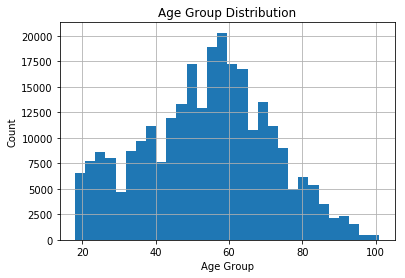

In [53]:
data.age.hist(bins = 30)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution');

In [54]:
data.income.describe()

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

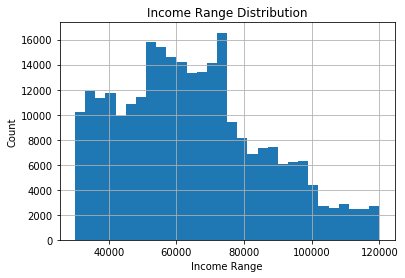

In [55]:
data.income.hist(bins = 30);
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Range Distribution');

In [56]:
data.gender.value_counts()

M    155690
F    113101
O      3971
Name: gender, dtype: int64

In [57]:
male_proportion  = data.gender.value_counts()[0] / data.shape[0]*100
female_proportion = data.gender.value_counts()[1] / data.shape[0]*100
others_proportion = data.gender.value_counts()[2] / data.shape[0]*100

male_proportion ,female_proportion ,others_proportion

(57.079065265689501, 41.465086778950145, 1.4558479553603507)

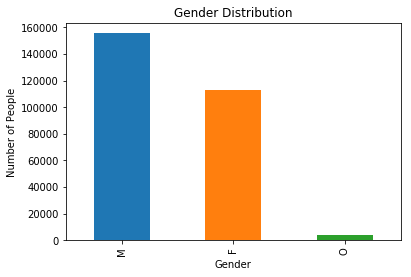

In [58]:
ax = data.gender.value_counts()
ax.plot(kind='bar')
plt.ylabel('Number of People')
plt.xlabel('Gender')
plt.title('Gender Distribution');

In [59]:
offer_received = data[data['offer-received'] == 1].offer_type.value_counts()
offer_viewed = data[data['offer-viewed'] == 1].offer_type.value_counts()
offer_completed = data[data['offer-completed'] == 1].offer_type.value_counts()

offer_received , offer_viewed , offer_completed

(discount         26664
 bogo             26537
 informational    13300
 Name: offer_type, dtype: int64, bogo             22039
 discount         18461
 informational     9360
 Name: offer_type, dtype: int64, discount    17186
 bogo        15258
 Name: offer_type, dtype: int64)

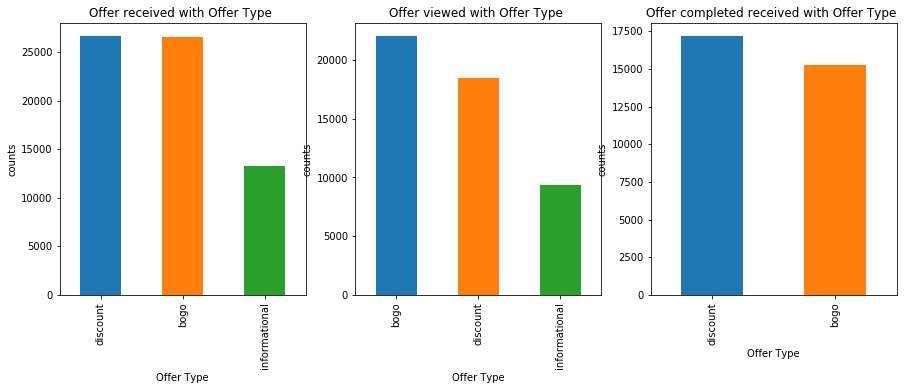

In [60]:
plt.subplot(131)
offer_received = data[data['offer-received'] == 1].offer_type.value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer received with Offer Type ');

plt.subplot(132)
offer_viewed = data[data['offer-viewed'] == 1].offer_type.value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer viewed with Offer Type ');

plt.subplot(133)
offer_completed = data[data['offer-completed'] == 1].offer_type.value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer completed received with Offer Type ');

In [61]:
# For BOGO Offer :

R = offer_received[1] 
V = offer_viewed[0] 
C = offer_completed[1] 

view_prop = V/R
com_prop = C/R
R , V , C , view_prop , com_prop

(26537, 22039, 15258, 0.83050081018954669, 0.57497079549308516)

In [62]:

# For DISCOUNT Offer :

R = offer_received[0] 
V = offer_viewed[1] 
C = offer_completed[0] 

view_prop = V/R
com_prop = C/R
R , V , C , view_prop , com_prop

(26664, 18461, 17186, 0.69235673567356737, 0.64453945394539458)

In [63]:
offer_received = data[data['offer-received'] == 1].offer_id.value_counts()
offer_viewed = data[data['offer-viewed'] == 1].offer_id.value_counts()
offer_completed = data[data['offer-completed'] == 1].offer_id.value_counts()

offer_received , offer_viewed , offer_completed

(9.0     6726
 0.0     6685
 3.0     6683
 6.0     6657
 8.0     6655
 7.0     6652
 2.0     6643
 5.0     6631
 10.0    6593
 4.0     6576
 Name: offer_id, dtype: int64, 7.0     6407
 8.0     6379
 10.0    6329
 4.0     6310
 3.0     5901
 2.0     5873
 0.0     3499
 6.0     3487
 5.0     3460
 9.0     2215
 Name: offer_id, dtype: int64, 7.0     5003
 8.0     4886
 0.0     4188
 4.0     4103
 5.0     3911
 3.0     3657
 9.0     3386
 10.0    3310
 Name: offer_id, dtype: int64)

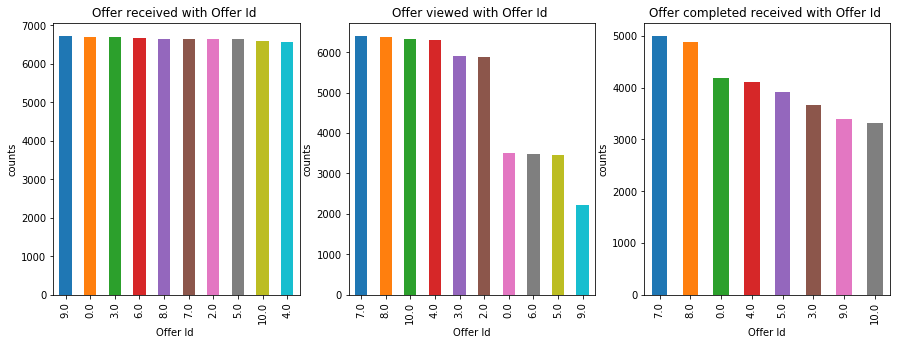

In [64]:
plt.subplot(131)
offer_received = data[data['offer-received'] == 1].offer_id.value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id ')
plt.title('Offer received with Offer Id ');

plt.subplot(132)
offer_viewed = data[data['offer-viewed'] == 1].offer_id.value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer viewed with Offer Id ');

plt.subplot(133)
offer_completed = data[data['offer-completed'] == 1].offer_id.value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Id')
plt.title('Offer completed received with Offer Id ');

In [65]:
data[data['offer_type']=='bogo'].groupby('customer_id')['offer-received'].count()

customer_id
0009655768c64bdeb2e877511632db8f     3
0011e0d4e6b944f998e987f904e8c1e5     3
0020c2b971eb4e9188eac86d93036a77     4
0020ccbbb6d84e358d3414a3ff76cffd     6
004b041fbfe44859945daa2c7f79ee64     3
004c5799adbf42868b9cff0396190900     8
005500a7188546ff8a767329a2f7c76a     8
0056df74b63b4298809f0b375a304cf4     3
00715b6e55c3431cb56ff7307eb19675     5
0082fd87c18f45f2be70dbcbb0fb8aad     5
00840a2ca5d2408e982d56544dc14ffd     2
00857b24b13f4fe0ad17b605f00357f5     7
008d7088107b468893889da0ede0df5c     6
0091d2b6a5ea4defaa8393e4e816db60    11
0099bf30e4cb4265875266eb3eb25eab     2
00a794f62b9a48beb58f8f6c02c2f1a6     5
00ae03011f9f49b8a4b3e6d416678b0b     5
00aee28bbb3848dd8a31f0c91dc267dd     4
00b18b535d6d4f779dea4dc9ac451478     2
00b3400e4ff64ee68ce9ada1d0c222f0     2
00b3c376db2a4115af3aef34a02f61d6     6
00b901d68f8f4fd68075184cd0f772d2     6
00bbce6533f44ddeaf4dd32bcab55441     3
00bc42a62f884b41a13cc595856cf7c3     3
00bc983061d3471e8c8e74d31b7c8b6f     4
00c20a9202d54

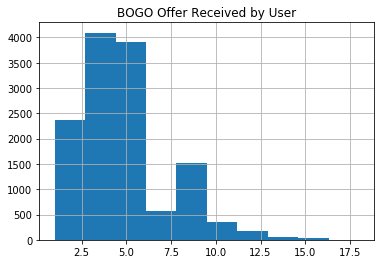

In [66]:
data[data['offer_type']=='bogo'].groupby('customer_id')['offer-received'].count().hist();
plt.title('BOGO Offer Received by User');

In [67]:
data[data['offer_type']=='informational'].groupby('customer_id')['offer-viewed'].count()

customer_id
0009655768c64bdeb2e877511632db8f    4
0011e0d4e6b944f998e987f904e8c1e5    4
0020c2b971eb4e9188eac86d93036a77    2
0020ccbbb6d84e358d3414a3ff76cffd    2
003d66b6608740288d6cc97a6903f4f0    4
00426fe3ffde4c6b9cb9ad6d077a13ea    2
004b041fbfe44859945daa2c7f79ee64    1
0056df74b63b4298809f0b375a304cf4    2
00715b6e55c3431cb56ff7307eb19675    1
0082fd87c18f45f2be70dbcbb0fb8aad    6
00840a2ca5d2408e982d56544dc14ffd    1
008d7088107b468893889da0ede0df5c    4
00a794f62b9a48beb58f8f6c02c2f1a6    6
00ae03011f9f49b8a4b3e6d416678b0b    2
00b18b535d6d4f779dea4dc9ac451478    2
00b3400e4ff64ee68ce9ada1d0c222f0    3
00bbce6533f44ddeaf4dd32bcab55441    2
00c5a385c71a4d3db5e9b4e31e430943    2
00c6035df45840038a72766c6d27a0db    2
00c91f31f5f74e769fa7a359b63e1a9f    3
00d6dc87be4146ceb47fcd4baaaf6477    1
00d791e20c564add8056498e40eb56cc    2
00d91c5919514448bc4f718e4e3f26ab    2
00e52682848542c3a6f59b7824e9a5c5    2
00e8d701c583461e81cc10053681a12b    2
00e9f403afa641889cd034ee7c7ca6e9    4


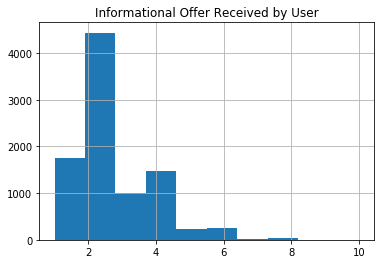

In [68]:
data[data['offer_type']=='informational'].groupby('customer_id')['offer-viewed'].count().hist();
plt.title('Informational Offer Received by User');

In [69]:
data[data['offer_type']=='discount'].groupby('customer_id')['offer-completed'].count()

customer_id
0009655768c64bdeb2e877511632db8f     5
0011e0d4e6b944f998e987f904e8c1e5     6
0020c2b971eb4e9188eac86d93036a77     5
0020ccbbb6d84e358d3414a3ff76cffd     3
003d66b6608740288d6cc97a6903f4f0     8
00426fe3ffde4c6b9cb9ad6d077a13ea     6
004b041fbfe44859945daa2c7f79ee64     3
004c5799adbf42868b9cff0396190900     6
005500a7188546ff8a767329a2f7c76a     1
0056df74b63b4298809f0b375a304cf4     5
00715b6e55c3431cb56ff7307eb19675     8
00840a2ca5d2408e982d56544dc14ffd     8
00857b24b13f4fe0ad17b605f00357f5     1
008d7088107b468893889da0ede0df5c     1
0091d2b6a5ea4defaa8393e4e816db60     3
0099bf30e4cb4265875266eb3eb25eab     8
00ae03011f9f49b8a4b3e6d416678b0b     8
00aee28bbb3848dd8a31f0c91dc267dd     1
00b18b535d6d4f779dea4dc9ac451478     9
00b3400e4ff64ee68ce9ada1d0c222f0     5
00b3c376db2a4115af3aef34a02f61d6     2
00b901d68f8f4fd68075184cd0f772d2     2
00bbce6533f44ddeaf4dd32bcab55441     6
00bc42a62f884b41a13cc595856cf7c3    11
00bc983061d3471e8c8e74d31b7c8b6f     3
00c20a9202d54

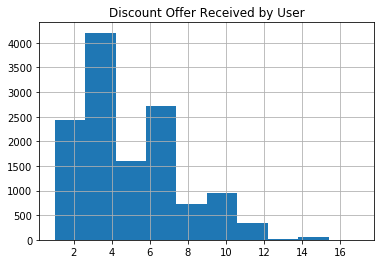

In [70]:
data[data['offer_type']=='discount'].groupby('customer_id')['offer-completed'].count().hist();
plt.title('Discount Offer Received by User');

In [71]:
genders = {'O': 0, 'M': 1, 'F': 2}
data['gender'] = data['gender'].map(genders)

In [72]:
data.offer_type.value_counts()

bogo             63834
discount         62311
informational    22660
Name: offer_type, dtype: int64

In [73]:
offers = {'bogo': 0, 'discount': 1, 'informational': 2}
data['offer_type'] = data['offer_type'].map(offers)

In [74]:
data.head()

,event,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,...,gender,income,difficulty,duration,offer_type,reward,mobile,social,web,event_id
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0.0,NaN,75,...,2,100000.0,5.0,7.0,0.0,5.0,1.0,0.0,1.0,0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0.0,NaN,75,...,2,100000.0,5.0,7.0,0.0,5.0,1.0,0.0,1.0,1
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,NaN,19.89,75,...,2,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0.0,NaN,75,...,2,100000.0,5.0,7.0,0.0,5.0,1.0,0.0,1.0,3
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,NaN,17.78,75,...,2,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [75]:
data.columns

Index(['event', 'customer_id', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'age',
       'became_member_on', 'gender', 'income', 'difficulty', 'duration',
       'offer_type', 'reward', 'mobile', 'social', 'web', 'event_id'],
      dtype='object')

In [76]:
X = data.drop(['customer_id', 'event_id' , 'event' , 'became_member_on','offer-completed', 'offer-received',
       'offer-viewed', 'transaction'], axis=1)
Y = data['event_id']

In [77]:
X.head()

,time,offer_id,amount,age,gender,income,difficulty,duration,offer_type,reward,mobile,social,web
0,0,0.0,NaN,75,2,100000.0,5.0,7.0,0.0,5.0,1.0,0.0,1.0
1,6,0.0,NaN,75,2,100000.0,5.0,7.0,0.0,5.0,1.0,0.0,1.0
2,132,NaN,19.89,75,2,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,132,0.0,NaN,75,2,100000.0,5.0,7.0,0.0,5.0,1.0,0.0,1.0
4,144,NaN,17.78,75,2,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
Y.head()

0    0
1    1
2    2
3    3
4    2
Name: event_id, dtype: int64

In [79]:
X.shape , Y.shape

((272762, 13), (272762,))

In [80]:
class_name =['offer recieved', 'offer viewed', 'transaction', 'offer completed']

In [81]:
#split the dataset into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [82]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((190933, 13), (81829, 13), (190933,), (81829,))

In [83]:
std = StandardScaler()

In [84]:
X_train.income = std.fit_transform(X_train.income.values.reshape(-1, 1))
X_train.age = std.fit_transform(X_train.age.values.reshape(-1, 1))

X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [85]:
X_test.income = std.transform(X_test.income.values.reshape(-1, 1))
X_test.age = std.fit_transform(X_test.age.values.reshape(-1, 1))

X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [86]:
X_train.shape, X_test.shape

((190933, 13), (81829, 13))

In [87]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [88]:
# Add these two lines to reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

In [89]:
import tensorflow.contrib.keras as keras
from tensorflow.contrib.keras.python.keras.models import Sequential

In [90]:
ann = keras.models.Sequential()

In [92]:
ann.add(keras.layers.Dense(6, activation='relu', input_dim=X_train.shape[1]))
ann.add(keras.layers.Dense(6, activation='relu'))
ann.add(keras.layers.Dense(4, activation='softmax'))

In [93]:
ann.compile(optimizer = 'adam', 
            loss = 'sparse_categorical_crossentropy', 
            metrics = ['accuracy'])

In [94]:
ann_history = ann.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100)

Train on 190933 samples, validate on 81829 samples
Epoch 1/15
190933/190933 [==============================] - 3s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 2/15
190933/190933 [==============================] - 2s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 3/15
190933/190933 [==============================] - 2s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 4/15
190933/190933 [==============================] - 2s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 5/15
190933/190933 [==============================] - 2s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 6/15
190933/190933 [==============================] - 3s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 7/15
190933/190933 [==============================] - 2s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 8/15
190933/190933 [==============================] - 2s - loss: nan - acc: 0.2434

In [95]:
ann.summary()       
# Summary of our model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6)                 84        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 28        
Total params: 154
Trainable params: 154
Non-trainable params: 0
_________________________________________________________________


In [97]:
ann_history.params

{'batch_size': 100,
 'epochs': 15,
 'samples': 190933,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}

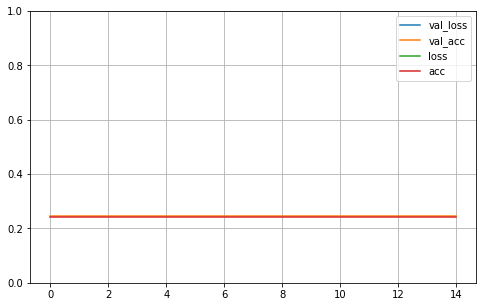

In [99]:
pd.DataFrame(ann_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)               # Y AXIS RANGE LIMIT 
plt.show()

In [100]:
ann.evaluate(X_test , y_test)

80128/81829 [============================>.] - ETA: 0s

[nan, 0.2448154077419889]

In [101]:
data.columns

Index(['event', 'customer_id', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'age',
       'became_member_on', 'gender', 'income', 'difficulty', 'duration',
       'offer_type', 'reward', 'mobile', 'social', 'web', 'event_id'],
      dtype='object')

In [103]:
X = data.drop(['customer_id', 'event_id' ,  'amount','event' , 'became_member_on','offer-completed', 'offer-received',
       'offer-viewed', 'mobile', 'social', 'web', 'time','transaction', 'duration'], axis=1)
Y = data['event_id']

In [104]:
X.head()

,offer_id,age,gender,income,difficulty,offer_type,reward
0,0.0,75,2,100000.0,5.0,0.0,5.0
1,0.0,75,2,100000.0,5.0,0.0,5.0
2,NaN,75,2,100000.0,NaN,NaN,NaN
3,0.0,75,2,100000.0,5.0,0.0,5.0
4,NaN,75,2,100000.0,NaN,NaN,NaN


In [105]:
X.shape , Y.shape

((272762, 7), (272762,))

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [107]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((190933, 7), (81829, 7), (190933,), (81829,))

In [108]:
X_train.income = std.fit_transform(X_train.income.values.reshape(-1, 1))
X_train.age = std.fit_transform(X_train.age.values.reshape(-1, 1))

X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [109]:
X_test.income = std.transform(X_test.income.values.reshape(-1, 1))
X_test.age = std.fit_transform(X_test.age.values.reshape(-1, 1))

X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [110]:
# Convert the pandas dataframe into numpy array

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [111]:
ann = keras.models.Sequential()

In [112]:
ann.add(keras.layers.Dense(32, input_dim=7, kernel_initializer = 'normal' ,activation='relu'))
ann.add(keras.layers.Dense(15, kernel_initializer = 'normal' ,activation='relu'))
ann.add(keras.layers.Dense(10, kernel_initializer = 'normal' ,activation='relu'))
ann.add(keras.layers.Dense(6, kernel_initializer = 'normal' ,activation='relu'))
ann.add(keras.layers.Dense(4, kernel_initializer = 'normal' ,activation = 'softmax'))

In [113]:
ann.compile(optimizer = 'adam', 
            loss = 'sparse_categorical_crossentropy', 
            metrics = ['accuracy'])

In [114]:
ann_history = ann.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100 , verbose = 2)

Train on 190933 samples, validate on 81829 samples
Epoch 1/15
3s - loss: nan - acc: 0.2433 - val_loss: nan - val_acc: 0.2448
Epoch 2/15
3s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 3/15
3s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 4/15
3s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 5/15
3s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 6/15
3s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 7/15
3s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 8/15
3s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 9/15
3s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 10/15
3s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 11/15
3s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 12/15
3s - loss: nan - acc: 0.2434 - val_loss: nan - val_acc: 0.2448
Epoch 13/15
3s - loss: nan - acc: 0.2434 - val_loss: nan -

In [115]:
ann.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 15)                495       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 66        
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 28        
Total params: 1,005
Trainable params: 1,005
Non-trainable params: 0
_________________________________________________________________


In [117]:
ann_history.params

{'batch_size': 100,
 'epochs': 15,
 'samples': 190933,
 'verbose': 2,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}

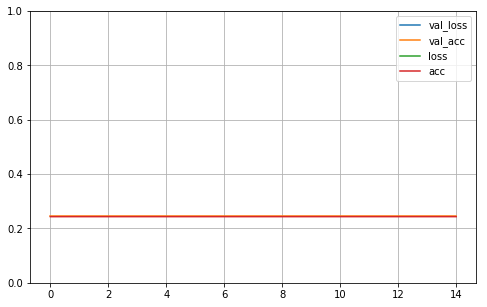

In [119]:
pd.DataFrame(ann_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)               # Y AXIS RANGE LIMIT 
plt.show()

In [120]:
ann.evaluate(X_test , y_test)

79648/81829 [============================>.] - ETA: 0s

[nan, 0.2448154077419889]

In [121]:
# TO PERFORM OF CHECK THE RESULT IN NEW DATA SET
# AS WE DON'T HAVE NEW DATA SET , CREATE ONE FROM TEST DATA SET
# HOW TO PREDICT THE PROBABILITY and CLASSES IN UNSEEN DATA


x_new = X_test[:3]

In [122]:
# PROBABILITY OF EACH SET

y_prob = ann.predict(x_new)
y_prob.round(2)                        # RESULT IN 2 DECIMAL PLACE

array([[ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan]], dtype=float32)

In [123]:
# CLASS OF EACH SET 

y_pred = ann.predict_classes(x_new)
y_pred

3/3 [==============================] - 0s


array([0, 0, 0])

In [124]:
np.array(class_name)[y_pred]

array(['offer recieved', 'offer recieved', 'offer recieved'], 
      dtype='<U15')